# Leukocytes - Model training

### Load the prepared training and validation subsets.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -U fastai

from fastai.vision.all import *
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Mounted at /content/drive


In [3]:
csv_path = Path('/content/drive/MyDrive/ColabNotebooks/dataframes/leukocytes_splits.csv')
df = pd.read_csv(csv_path)

df_learning = df[df['set'].isin(['train', 'valid'])].copy()
df_learning['is_valid'] = df_learning['set'] == 'valid'

df_learning.head(), df_learning['set'].value_counts()

(                                                                     filepath  \
 0  /content/drive/MyDrive/CVData/dataset_leukocytes/neutrophil/BNE_240705.jpg   
 1      /content/drive/MyDrive/CVData/dataset_leukocytes/monocyte/MO_12336.jpg   
 2   /content/drive/MyDrive/CVData/dataset_leukocytes/eosinophil/EO_152760.jpg   
 3     /content/drive/MyDrive/CVData/dataset_leukocytes/monocyte/MO_967515.jpg   
 4     /content/drive/MyDrive/CVData/dataset_leukocytes/eosinophil/EO_6489.jpg   
 
         label    set  is_valid  
 0  neutrophil  train     False  
 1    monocyte  train     False  
 2  eosinophil  train     False  
 3    monocyte  train     False  
 4  eosinophil  train     False  ,
 set
 train    1750
 valid     375
 Name: count, dtype: int64)

### Design and train a model using the fastai library. You may implement a convolutional neural network (CNN) or a Vision Transformer (ViT), depending on your strategy and reasoning.

A Convolutional Neural Network (CNN) is chosen rather than a Vision Transformer (ViT). CNNs have a strong inductive bias for recognizing local spatial patterns such as edges, textures, and shapes — features that are highly relevant for leukocyte morphology. ViTs, while powerful, generally rely less on these spatial priors and often require stronger regularization strategies or extensive augmentation to reach similar performance in medical imaging tasks.

Concretely, a VGG11 model is chosen with batch normalization, initialized with ImageNet pre-trained weights. Starting from a pre-trained model helps because the early layers already capture basic visual features such as edges and simple textures. This usually leads to faster convergence during fine-tuning and reduces the amount of training required to reach good performance.

The fastai vision_learner function builds on top of this backbone by attaching a new classification head suited for the five leukocyte classes. It also sets up the appropriate loss function, optimizer, and metrics, which keeps the training pipeline straightforward while still giving strong results.

In [4]:
standardization = Normalize.from_stats(*imagenet_stats)

In [5]:
batch_size = 32 # TODO: ALSO TRY DIFFERENT BATCH SIZE for convergence/performance

# Data augmentation and normalization in batch_tfms
batch_tfms = [*aug_transforms(
                flip_vert=True,       # vertical flips allowed for smear images
                max_rotate=10,        # small rotations
                max_zoom=1.1,         # slight zoom
                max_lighting=0.2,     # brightness/contrast
                max_warp=0.1          # small warps
             ),
             standardization]

/usr/local/lib/python3.12/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/usr/local/lib/python3.12/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/usr/local/lib/python3.12/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']


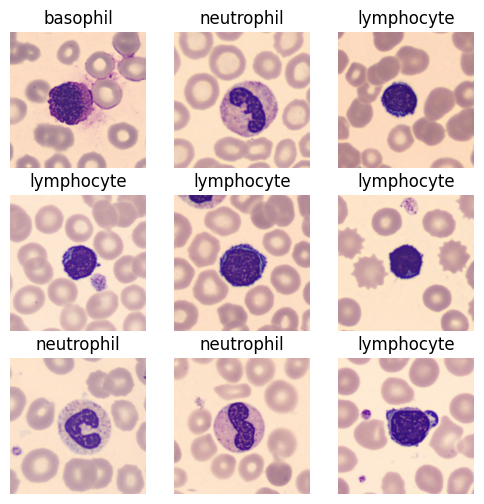

In [6]:
dls = ImageDataLoaders.from_df(
    df_learning,
    path='/',                    # because 'filepath' is absolute
    cols='filepath',             # column with image path
    label_col='label',           # column with label
    valid_col='is_valid',        # boolean split column
    item_tfms=Resize(224),       # resize for VGG11
    batch_tfms=batch_tfms,
    bs=batch_size
)

dls.show_batch(max_n=9, figsize=(6, 6))
print("Classes:", dls.vocab)

VGG11 is used with batch normalization because VGG-family networks have been widely and successfully applied to white blood cell classification, thanks to their strong performance on texture- and shape-based tasks and their relatively simple architecture, which facilitates analysis and comparison.

In [7]:
from torchvision import models

model_CNN =  models.vgg11_bn
weights_CNN = models.VGG11_BN_Weights.DEFAULT

In [8]:
learn = vision_learner(dls, model_CNN, metrics=accuracy, weights=weights_CNN)
learn

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


100%|██████████| 507M/507M [00:06<00:00, 88.2MB/s]


Suggested Learning Rate (valley): 0.0008317637839354575


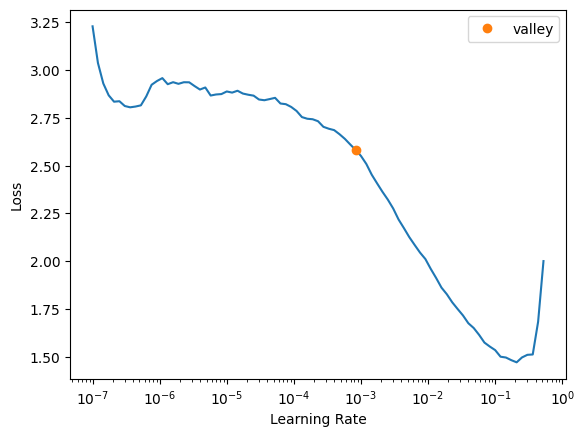

In [9]:
lr_finder = learn.lr_find() # exploring different LR
print("Suggested Learning Rate (valley):", lr_finder.valley)

The lr_find function suggested a good LR around 2.5e-3 (valley). In the next block this value is rounded to 3e-3 as base learning rate, which still lies inside the stable valley region.


In [10]:
cbs = [
    EarlyStoppingCallback(monitor='valid_loss', patience=3), # stops training if validation loss hasn't improved for 3 epoch
    SaveModelCallback(monitor='accuracy', fname='vgg11_best'),
    CSVLogger(fname='vgg11_training_log.csv') # log metrics
]

# 12 epoch
learn.fine_tune(12, base_lr=3e-3, cbs=cbs, reset_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.935040,0.204795,0.933333,01:13


Better model found at epoch 0 with accuracy value: 0.9333333373069763.


epoch,train_loss,valid_loss,accuracy,time
0,0.240125,0.092761,0.968000,00:18
1,0.177778,0.049338,0.984000,00:18
2,0.122746,0.067795,0.978667,00:18
3,0.099466,0.058185,0.986667,00:19
4,0.095021,0.031071,0.989333,00:18
5,0.065512,0.031269,0.989333,00:18
6,0.053098,0.018606,0.992000,00:19
7,0.041541,0.015162,0.997333,00:18
8,0.027142,0.014820,0.994667,00:18
9,0.026142,0.011702,0.994667,00:18


Better model found at epoch 0 with accuracy value: 0.9679999947547913.
Better model found at epoch 1 with accuracy value: 0.984000027179718.
Better model found at epoch 3 with accuracy value: 0.9866666793823242.
Better model found at epoch 4 with accuracy value: 0.9893333315849304.
Better model found at epoch 6 with accuracy value: 0.9919999837875366.
Better model found at epoch 7 with accuracy value: 0.9973333477973938.


### Visualize training and validation accuracy/loss curves to evaluate model convergence and possible overfitting

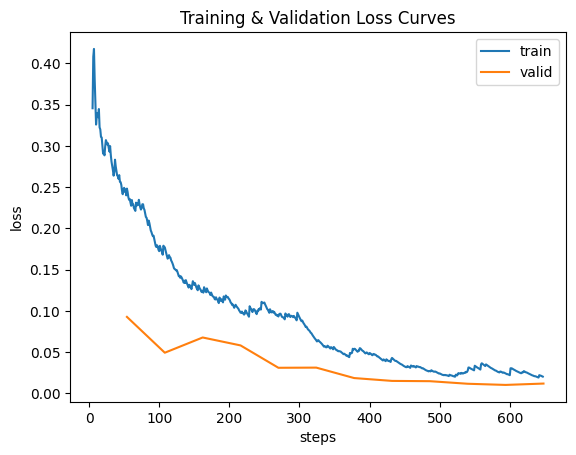

In [11]:
learn.recorder.plot_loss()
plt.title("Training & Validation Loss Curves")
plt.show()

The training loss decreases smoothly, showing effective learning. The validation loss also decreases overall with only small fluctuations caused by mini-batch updates. Since both curves trend downward and stay close to each other, there is no evidence of overfitting. The model’s generalization improves steadily throughout training.

In [12]:
for i, row in enumerate(learn.recorder.values):
    train_loss, valid_loss, acc = row
    print(f"Epoch {i:02d} | train_loss={train_loss:.4f} | valid_loss={valid_loss:.4f} | acc={acc:.4f}")

Epoch 00 | train_loss=0.2401 | valid_loss=0.0928 | acc=0.9680
Epoch 01 | train_loss=0.1778 | valid_loss=0.0493 | acc=0.9840
Epoch 02 | train_loss=0.1227 | valid_loss=0.0678 | acc=0.9787
Epoch 03 | train_loss=0.0995 | valid_loss=0.0582 | acc=0.9867
Epoch 04 | train_loss=0.0950 | valid_loss=0.0311 | acc=0.9893
Epoch 05 | train_loss=0.0655 | valid_loss=0.0313 | acc=0.9893
Epoch 06 | train_loss=0.0531 | valid_loss=0.0186 | acc=0.9920
Epoch 07 | train_loss=0.0415 | valid_loss=0.0152 | acc=0.9973
Epoch 08 | train_loss=0.0271 | valid_loss=0.0148 | acc=0.9947
Epoch 09 | train_loss=0.0261 | valid_loss=0.0117 | acc=0.9947
Epoch 10 | train_loss=0.0246 | valid_loss=0.0103 | acc=0.9947
Epoch 11 | train_loss=0.0203 | valid_loss=0.0119 | acc=0.9947


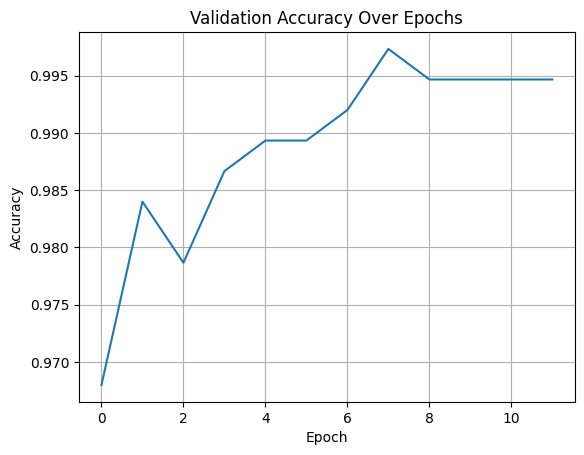

In [13]:
acc_values = [m[2] for m in learn.recorder.values]
plt.plot(acc_values)
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [14]:
learn.load("vgg11_best")
print("Loaded best model: vgg11_best")

Loaded best model: vgg11_best


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


#### Final training configuration

- Architecture: VGG11 with batch normalization (pre-trained on ImageNet)
- Input size: 224 × 224
- Batch size: 32
- Optimizer: Adam (fastai default, with One-Cycle learning rate schedule)
- Base learning rate: 3e-3 (chosen from lr_find “valley” region)
- Training strategy: fine_tune(12) with early stopping (patience = 3)
- Data augmentation: rotations (±10°), flips, small zoom (≤ 1.1), lighting and warp perturbations
- Normalization: ImageNet statistics


### Save your best-performing model

In [15]:
learn.export('/content/drive/MyDrive/ColabNotebooks/models/model.pkl')
print("Model exported as 'model.pkl'")

Model exported as 'model.pkl'
